## Hackathon 3 : Sentiment Classification

<b>Problem Statement</b>
<p>Twitter has now become a useful way to build one's business as it helps in giving the brand a voice and a personality. The platform is also a quick, easy and inexpensive way to gain valuable insight from the desired audience. Identifying the sentiments about the product/brand can help the business take better actions.</p>

You have with you evaluated tweets about multiple brands. The evaluators(random audience) were asked if the tweet expressed positive, negative, or no emotion towards a product/brand and labelled accordingly.

<b>Dataset Description</b> 
<p>This dataset contains around 7k tweet text with the sentiment label.

The file train.csv has 3 columns

tweet_id - Unique id for tweets. tweet - Tweet about the brand/product sentiment - 0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell </p>

<b>Evaluation Metric</b> 
<p> We will be using ‘weighted’ F1-measure as the evaluation metric for this competition. For more information on the F1-metric refer to https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html  </p>

<b>Submission format</b> 
<p> Submission file should have two columns, one for tweet_id and sencond for sentiment [0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell]. A sample submission file has also been attached for reference. </p>

## Start of Notebook

#### Why are we doing this
- To Classify the Tweets into positive , neutral , negative, Cant tell
- To Identify sentiments of product/brand

#### Stakeholders:
- Customer of Withwicky 
- DataScience head or Project Manager of WithWicky

In [ ]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from html.parser import HTMLParser
from textblob import TextBlob
import string
from spellchecker import SpellChecker
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,classification_report
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from autocorrect import Speller
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC

import plotly.offline as pyo
from plotly import graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode()

#### Import DataSet

In [2]:
traindf = pd.read_csv("train.csv")
#testdf = pd.read_csv("test.csv")

In [3]:
traindf.dtypes

tweet_id      int64
tweet        object
sentiment     int64
dtype: object

## EDA

#### Checking Train DataSet

In [4]:
traindf.head()

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of tou...,1
1,1851,Learning ab Google doodles! All doodles should...,1
2,2689,one of the most in-your-face ex. of stealing t...,2
3,4525,This iPhone #SXSW app would b pretty awesome i...,0
4,3604,Line outside the Apple store in Austin waiting...,1


In [5]:
temp = traindf.groupby('sentiment').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)

In [6]:
temp

,sentiment,tweet
1,1,4310
2,2,2382
0,0,456
3,3,125


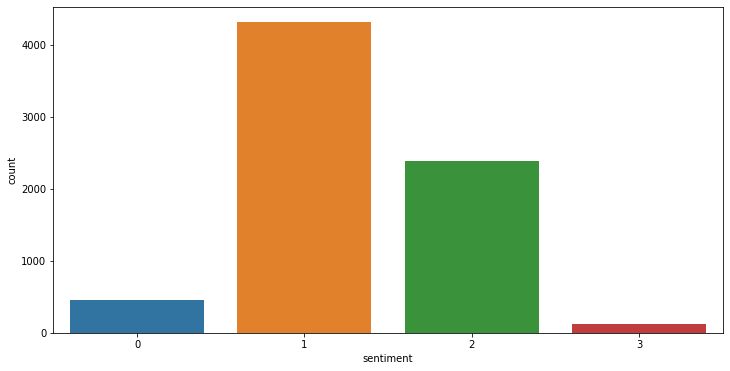

In [7]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=traindf)

In [8]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.tweet,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))

fig.show()

In [9]:
traindf.info

<bound method DataFrame.info of       tweet_id                                              tweet  sentiment
0         1701  #sxswnui #sxsw #apple defining language of tou...          1
1         1851  Learning ab Google doodles! All doodles should...          1
2         2689  one of the most in-your-face ex. of stealing t...          2
3         4525  This iPhone #SXSW app would b pretty awesome i...          0
4         3604  Line outside the Apple store in Austin waiting...          1
...        ...                                                ...        ...
7269      3343  @mention Google plze Tammi.  I'm in middle of ...          1
7270      5334  RT @mention ÷¼ Are you all set? ÷_ {link} ÷...          1
7271      5378  RT @mention Aha! Found proof of lactation room...          1
7272      2173  We just launched our iPad app at #SXSW! Get al...          1
7273      3162  The next fin serv battle is vs Apple, GOOG, Mo...          1

[7274 rows x 3 columns]>

In [10]:
traindf.dtypes

tweet_id      int64
tweet        object
sentiment     int64
dtype: object

In [11]:
traindf.head()


,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of tou...,1
1,1851,Learning ab Google doodles! All doodles should...,1
2,2689,one of the most in-your-face ex. of stealing t...,2
3,4525,This iPhone #SXSW app would b pretty awesome i...,0
4,3604,Line outside the Apple store in Austin waiting...,1


In [12]:
traindf.info

<bound method DataFrame.info of       tweet_id                                              tweet  sentiment
0         1701  #sxswnui #sxsw #apple defining language of tou...          1
1         1851  Learning ab Google doodles! All doodles should...          1
2         2689  one of the most in-your-face ex. of stealing t...          2
3         4525  This iPhone #SXSW app would b pretty awesome i...          0
4         3604  Line outside the Apple store in Austin waiting...          1
...        ...                                                ...        ...
7269      3343  @mention Google plze Tammi.  I'm in middle of ...          1
7270      5334  RT @mention ÷¼ Are you all set? ÷_ {link} ÷...          1
7271      5378  RT @mention Aha! Found proof of lactation room...          1
7272      2173  We just launched our iPad app at #SXSW! Get al...          1
7273      3162  The next fin serv battle is vs Apple, GOOG, Mo...          1

[7274 rows x 3 columns]>

## Stop Words Removal

stopwords.words('english')


In [13]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

#### Data Cleaning

In [14]:
# Function for converting emoticons into word
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', " ".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

In [15]:
convert_emoticons("Awwww yeah!!! RT @mention Congrats to @mention on winning the last @mention #iPad case for her boyfriend aw :) #SXSW #cbatsxsw")

'Awwww yeah!!! RT @mention Congrats to @mention on winning the last @mention #iPad case for her boyfriend aw Happy face or smiley #SXSW #cbatsxsw'

In [16]:
traindf.tweet[220]

'Awwww yeah!!! RT @mention Congrats to @mention on winning the last @mention #iPad case for her boyfriend aw :) #SXSW #cbatsxsw'

In [17]:
def dataCleaning(df,stemming = False, lemmatization=False):
    html_parser = HTMLParser()
    
    # convert column type to string
    df['tweet'] = df['tweet'].astype(str)
    
    
    # to lower case
    df['tweet'] = df['tweet'].apply(lambda x: x.lower())
    
    #stopword removal  , removed NOT from STOP-WORDS
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    stop_words = all_stopwords
    traindf['tweet'] =  traindf['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    
    #removing @mention
    df['tweet']= df['tweet'].apply(lambda x: re.sub('(@[mention]+)',' ',x))
    
    #removing @handles , since trending tweets are on Hashtags
    df['tweet']= df['tweet'].apply(lambda x: re.sub('(@[A-Za-z0-9]+)',' ',x))
    
     #removing Http links , since trending tweets are on Hashtags
    df['tweet']= df['tweet'].apply(lambda x: re.sub('http\S+',' ',x))
    
    #converting emoticon
    df['tweet']= df['tweet'].apply(lambda x: convert_emoticons(x))
    
    #handling apostrophe
    df['tweet']= df['tweet'].apply(lambda x: re.sub("’", "'",x))
    
    
   
    # remove numbers
    df['tweet']= df['tweet'].apply(lambda x: re.sub(r'\d+', ' ', x))
    

    # remove punctuations and convert characters to lower case
    df['tweet'] = df['tweet'].apply(lambda x: "".join([char.lower() for char in x if char not in string.punctuation]))
    
    #converting Html Encoding
    
    df['tweet']= df['tweet'].apply(lambda x: html_parser.unescape(x))
    
    #removing #HashTags 
    #df['tweet']= df['tweet'].apply(lambda x: re.sub('(#[A-Za-x0-9\\_\\]+)',' ',x))
    
    # #removing '#' symbol 
    df['tweet']= df['tweet'].apply(lambda x: re.sub('(#+)',' ',x))
     
    
    #replacing double whitespace with single 
    df['tweet']= df['tweet'].apply(lambda x: re.sub(' +', ' ',x))
    
    #Removing RT
    df['tweet']= df['tweet'].apply(lambda x: re.sub('(rt)\W', ' ',x))
    
    if stemming:
        st = SnowballStemmer('english')
        df['tweet'] = df['tweet'].apply(lambda x: " ".join([st.stem(w) for w in x.split()]))
                                        
    if lemmatization:
        wordnet_lemmatizer = WordNetLemmatizer()
        df['tweet'] = df['tweet'].apply(lambda x: " ".join([wordnet_lemmatizer.lemmatize(w, pos='v') for w in x.split()]))
    
#     #Spelling Correction
#     df['tweet']= df['tweet'].apply(lambda x: TextBlob(x).correct() )
      
    
    return df

In [18]:
traindf = dataCleaning(traindf,stemming=True,lemmatization=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning:

The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.



In [19]:
traindf.tweet[220]

'awwww yeah congrat win last ipad case boyfriend aw happi face or smiley sxsw cbatsxsw'

In [20]:
traindf.head()

,tweet_id,tweet,sentiment
0,1701,sxswnui sxsw appl defin languag touch differ d...,1
1,1851,learn ab googl doodl doodl light funni amp inn...,1
2,2689,one inyourfac ex steal show yrs quotat sxsw ap...,2
3,4525,iphon sxsw app would b pretti awesom crash eve...,0
4,3604,line outsid appl store austin wait new ipad sx...,1


tfidf = TfidfVectorizer(stop_words="english")

In [21]:
tfidf = TfidfVectorizer()

In [22]:
vector_tfidf = tfidf.fit_transform(traindf["tweet"])



In [23]:
X_tfidf = vector_tfidf.toarray()


In [24]:
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
print("df",X_tfidf.shape)

df (7274, 7757)


In [26]:
traindf['sentiment']

0       1
1       1
2       2
3       0
4       1
       ..
7269    1
7270    1
7271    1
7272    1
7273    1
Name: sentiment, Length: 7274, dtype: int64

## WORKING DO NOT REMOVE

X = X_tfidf

# Target
y = traindf['sentiment']
lr = LogisticRegression()
print(":::")
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
    
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print('Classification Report:')
print(classification_report(y_test,y_pred))
print('F1 weighted score:', f1_score(y_test, y_pred, average='weighted'))


testdf = pd.read_csv("test.csv")
testdf = dataCleaning(testdf,stemming=True,lemmatization=False)
print("testdf, ",testdf.shape)

test_id_col = testdf['tweet_id']
print("test_id_col ",test_id_col.shape)

print("Dropping Id column")
test_df_drop_id = testdf.drop(['tweet_id'],axis=1)
print("test_df_drop_id ",test_df_drop_id.shape)

print('Transform Test DataSet using TFiDF')
#Transform Test DataSet using TFiDF
testdf_tfidf = tfidf.transform(test_df_drop_id['tweet'])

print('Predicting TestValues')
#Predicting TestValues
predict = lr.predict(testdf_tfidf)
  
print(predict.shape)
print(test_df_drop_id.shape)

print('Adding Test prediction to Column')
#Adding Test prediction to Column
test_df_drop_id['sentiment']= lr.predict(testdf_tfidf)
    
print('Concat both column to Pandas')
#Concat both column to Pandas
submissions_lr = pd.concat([test_id_col, test_df_drop_id['sentiment']], axis=1) 
    
#Creating CSV
submissions_lr.to_csv('submissions_Logistic.csv', index=False) 
    
print("successfully completed ")

In [27]:
logistic_param = dict(
                    #penalty= ['l1', 'l2','elasticnet'],
    #penalty= ['elasticnet'],
                  C= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100] ,
                  solver=['liblinear', 'saga','sag','lbfgs']
                #  solver=['saga']
                  )

In [28]:
logistic_param

{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
 'solver': ['liblinear', 'saga', 'sag', 'lbfgs']}

In [29]:
MultiNBparams = dict(alpha= [0.5,1, 1.5],
               fit_prior = [True, False] )

In [30]:
SGDparams = dict(
                  penalty= ['l1', 'l2','elasticnet'] 
                )

In [31]:
DecisionTreeClassifierparams = dict(
                               criterion = ['gini','entropy'],
                               splitter= ['best','random']
                                )

In [32]:
# Number of trees in random forest
n_estimators = [100,150,200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [20,25]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]


# Create the random grid
RandomForestClassifierparam = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [33]:
BernoulliNBparam = {
                    'fit_prior':[True,False]
}

In [34]:
ExtraTreesClassifierParam = {
    'criterion':['gini','entropy']
    
}

In [35]:
ParamsGrid = [ logistic_param ,MultiNBparams,SGDparams,DecisionTreeClassifierparams,RandomForestClassifierparam ,BernoulliNBparam,ExtraTreesClassifierParam  ]

# RESEARCH WORK -- DONT TOUCH"

# Custom Objects

SimplexgbClassifier = XGBClassifier()
SoftMax_Simple_xgbClassifier = XGBClassifier(objective='multi:softmax')
XGBRFClassifier = XGBRFClassifier()

parameters = {'learning_rate': [0.01,0.02],
                  'max_depth'    : [4,6] 
                 }

In [36]:
def run_model(predictors,target,test_df, model,model_name,params):
    print("inside "+model_name)
    predictors.shape
    target.shape
    print(":::")
    
    x_train,x_test,y_train,y_test = train_test_split(predictors,target,test_size=0.3,random_state=42)
    
    #SMOTE
    sm = SMOTE()
    x_train_new, y_train_new = sm.fit_sample(x_train,y_train)
    
    #grid
    grid = GridSearchCV(estimator=model,param_grid = params, cv = 5, n_jobs=2, verbose=9)
    
    grid.fit(x_train_new, y_train_new)
    y_pred = grid.predict(x_test)
    print('Classification Report:')
    print(classification_report(y_test,y_pred))
    #false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    print('F1 weighted score:', f1_score(y_test, y_pred, average='weighted'))
    
#     #For TEST DataSet
#     if 'test_df' in locals():
#         del test_df
#         del test_id_col
#         del test_df_drop_id
#         del testdf_tfidf
    
#     if 'testdf' in globals():
#         del testdf
#         del test_id_col
#         del test_df_drop_id
#         del testdf_tfidf
    
   # testdf = pd.read_csv("test.csv")
   # testdf = dataCleaning(testdf,stemming=True,lemmatization=False)
    print("testdf, ",test_df.shape)
    
    test_id_col = test_df['tweet_id']
    print("test_id_col ",test_id_col.shape)
    
    print("Dropping Id column")
    test_df_drop_id = test_df.drop(['tweet_id'],axis=1)
    print("test_df_drop_id ",test_df_drop_id.shape)
    
    #Transform Test DataSet using TFiDF
    testdf_tfidf = tfidf.transform(test_df_drop_id['tweet'])
    
    #Predicting TestValues
    print('Predicting TestValues')
    predict = grid.predict(testdf_tfidf)
  
    print(predict.shape)
    print(test_df_drop_id.shape)

    print('Adding Test prediction to Column')
    #Adding Test prediction to Column
    test_df_drop_id['sentiment']= grid.predict(testdf_tfidf)
    
    print('Concat both column to Pandas')
    #Concat both column to Pandas
    submissions_nb = pd.concat([test_id_col, test_df_drop_id['sentiment']], axis=1) 
    
    print('Creating CSV')
    #Creating CSV
    submissions_nb.to_csv('submissions_'+model_name+'.csv', index=False) 
    
    print("successfully completed "+model_name)

In [ ]:
# Predictors
X = X_tfidf

# Target
y = traindf['sentiment']

#TestDF
testdf = pd.read_csv("test.csv")
testdf = dataCleaning(testdf,stemming=True,lemmatization=False)

# Choosing the models. If you want to specify additional models, kindly specify them as a key-value pair as shown below.
# models = {'Logistic Regression':LogisticRegression,'Multinomial NaiveBais':MultinomialNB,'Linear SVM': SGDClassifier}
models = {'Logistic Regression':LogisticRegression,'Multinomial NaiveBais':MultinomialNB,'Linear SVM': SGDClassifier,
         'Decision Tree': DecisionTreeClassifier, 'RandomForestClassifier': RandomForestClassifier,
         'BernoulliNB':BernoulliNB , 'ExtraTreesClassifier' :ExtraTreesClassifier  }
    
p=0;
for i in models.items():
    # run model
    
    model = i[1]()
    model_name = i[0]
    print("X_Tfidf: ",X_tfidf.shape)
    print("senti shape: ",traindf['sentiment'].shape)
    run_model(X_tfidf, traindf['sentiment'],testdf, model,model_name,params= ParamsGrid[p]) # train and returns AUC test score
    p=p+1;
    print('===='*20)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning:

The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.



X_Tfidf:  (7274, 7757)
senti shape:  (7274,)
inside Logistic Regression
:::
Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    3.3s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  5.2min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  7.9min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed: 12.0min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 19.4min
[Parallel(n_jobs=2)]: Done 140 out of 140 | elapsed: 30.5min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.01      0.02       121
           1       0.66      0.90      0.77      1304
           2       0.61      0.35      0.45       719
           3       0.00      0.00      0.00        39

    accuracy                           0.66      2183
   macro avg       0.44      0.32      0.31      2183
weighted avg       0.63      0.66      0.61      2183

F1 weighted score: 0.6052163792759043
testdf,  (1819, 2)
test_id_col  (1819,)
Dropping Id column
test_df_drop_id  (1819, 1)
Predicting TestValues
(1819,)
(1819, 1)
Adding Test prediction to Column
Concat both column to Pandas
Creating CSV
successfully completed Logistic Regression

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.




X_Tfidf:  (7274, 7757)
senti shape:  (7274,)
inside Multinomial NaiveBais
:::
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    5.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   10.5s
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:   17.7s finished


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.04      0.08       121
           1       0.66      0.90      0.76      1304
           2       0.58      0.32      0.42       719
           3       0.00      0.00      0.00        39

    accuracy                           0.65      2183
   macro avg       0.47      0.32      0.31      2183
weighted avg       0.62      0.65      0.60      2183

F1 weighted score: 0.5971185999331485
testdf,  (1819, 2)
test_id_col  (1819,)
Dropping Id column
test_df_drop_id  (1819, 1)
Predicting TestValues
(1819,)
(1819, 1)
Adding Test prediction to Column
Concat both column to Pandas
Creating CSV
successfully completed Multinomial NaiveBais
X_Tfidf:  (7274, 7757)
senti shape:  (7274,)
inside Linear SVM
:::


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   40.1s
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  2.7min finished


Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.17      0.26       121
           1       0.70      0.82      0.76      1304
           2       0.58      0.49      0.53       719
           3       0.00      0.00      0.00        39

    accuracy                           0.66      2183
   macro avg       0.45      0.37      0.39      2183
weighted avg       0.64      0.66      0.64      2183

F1 weighted score: 0.6406442673914302
testdf,  (1819, 2)
test_id_col  (1819,)
Dropping Id column
test_df_drop_id  (1819, 1)
Predicting TestValues
(1819,)
(1819, 1)
Adding Test prediction to Column
Concat both column to Pandas
Creating CSV
successfully completed Linear SVM
X_Tfidf:  (7274, 7757)
senti shape:  (7274,)
inside Decision Tree
:::


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   20.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.4min finished


Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.25      0.29       121
           1       0.69      0.77      0.73      1304
           2       0.54      0.47      0.50       719
           3       0.06      0.03      0.04        39

    accuracy                           0.63      2183
   macro avg       0.41      0.38      0.39      2183
weighted avg       0.61      0.63      0.62      2183

F1 weighted score: 0.6171501017375749
testdf,  (1819, 2)
test_id_col  (1819,)
Dropping Id column
test_df_drop_id  (1819, 1)
Predicting TestValues
(1819,)
(1819, 1)
Adding Test prediction to Column
Concat both column to Pandas
Creating CSV
successfully completed Decision Tree
X_Tfidf:  (7274, 7757)
senti shape:  (7274,)
inside RandomForestClassifier
:::
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   20.8s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  3.8min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  6.2min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  8.7min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed: 11.8min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 15.5min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed: 19.7min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 24.4min
[Parallel(n_jobs=2)]: Done 238 tasks      | elapsed: 29.5min
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed: 35.7min
[Parallel(n_jobs=2)]: Done 334 tasks      | elapsed: 42.9min
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed: 50.1min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed: 57.9min


# RESEARCH -2

### XGBClassifier

In [ ]:
## WORKING DO NOT REMOVE

X = X_tfidf

# Target
y = traindf['sentiment']
#lr = XGBClassifier() 
lr = XGBClassifier(objective='multi:softmax')

print(":::")
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
    
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print('Classification Report:')
print(classification_report(y_test,y_pred))
print('F1 weighted score:', f1_score(y_test, y_pred, average='weighted'))


testdf = pd.read_csv("test.csv")
testdf = dataCleaning(testdf,stemming=True,lemmatization=False)
print("testdf, ",testdf.shape)

test_id_col = testdf['tweet_id']
print("test_id_col ",test_id_col.shape)

print("Dropping Id column")
test_df_drop_id = testdf.drop(['tweet_id'],axis=1)
print("test_df_drop_id ",test_df_drop_id.shape)

print('Transform Test DataSet using TFiDF')
#Transform Test DataSet using TFiDF
testdf_tfidf = tfidf.transform(test_df_drop_id['tweet'])

print('Predicting TestValues')
#Predicting TestValues
predict = lr.predict(testdf_tfidf)
  
print(predict.shape)
print(test_df_drop_id.shape)

print('Adding Test prediction to Column')
#Adding Test prediction to Column
test_df_drop_id['sentiment']= lr.predict(testdf_tfidf)
    
print('Concat both column to Pandas')
#Concat both column to Pandas
submissions_lr = pd.concat([test_id_col, test_df_drop_id['sentiment']], axis=1) 
    
#Creating CSV
submissions_lr.to_csv('submissions_SoftMax_Simple_xgbClassifier.csv', index=False) 
    
print("successfully completed ")

:::
